# JALAM Agent Training and Saving Pipeline

This notebook trains Joint Action Learning Agent Modelling (JALAM) agents for a variety of simultaneous games.
For each game, it:
1. Initializes the game environment and JALAM agents.
2. Trains the agents over a specified number of episodes and iterations.
3. Saves the learned models (e.g., Q-table, opponent models) for each agent.
4. Saves the training data (e.g., average rewards per iteration) for later analysis.

The saved models and data will be stored in the `jalam_trainings` directory, organized by game.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
import time # For potential rendering delays

# Game implementations
from games.rps import RPS
from games.mp import MP
from games.blotto import Blotto
from games.foraging import Foraging

# Agent implementation
from agents.jal_am_agent import JointActionLearningAgentModellingAgent

# Base classes (if needed for type hinting or direct use)
from base.game import SimultaneousGame, AgentID, ActionDict

## 1. Define Games and Configurations

Specify the games to be tested and their respective configurations.
The `get_game_instance` helper function will be used to create game objects.

In [2]:
games_to_test = [
    {"name": "RPS", "game_class": RPS, "config": {}, "train_episodes": 1000, "train_iterations": 500},
    {"name": "MP", "game_class": MP, "config": {}, "train_episodes": 1000, "train_iterations": 500},
    {"name": "Blotto_S3_N2", "game_class": Blotto, "config": {"S": 3, "N": 2}, "train_episodes": 2000, "train_iterations": 1000},
    {"name": "Foraging_5x5_2p_1f", "game_class": Foraging, "config": {"config": "Foraging-5x5-2p-1f-v3", "seed": 42}, "train_episodes": 1000, "train_iterations": 500}
]

def get_game_instance(game_entry: dict) -> SimultaneousGame:
    """Creates a game instance from a game entry."""
    game_class = game_entry["game_class"]
    config = game_entry["config"]
    if game_entry["name"].startswith("Blotto") or game_entry["name"].startswith("Foraging"):
        return game_class(**config)
    else:
        return game_class()

# Directory to save training outputs
TRAINING_DATA_DIR = "jalam_trainings"
if not os.path.exists(TRAINING_DATA_DIR):
    os.makedirs(TRAINING_DATA_DIR)
    print(f"Created directory: {TRAINING_DATA_DIR}")
else:
    print(f"Directory already exists: {TRAINING_DATA_DIR}")

Directory already exists: jalam_trainings


## 2. Helper Functions for Agent Creation, Training, and Saving

In [3]:
agent_config_params_global = {} # To store config for access in train_agents_for_game if needed

def create_agents(game: SimultaneousGame, agent_config_params: dict = None) -> dict[AgentID, JointActionLearningAgentModellingAgent]:
    """Creates JALAM agents for all agents in the game."""
    global agent_config_params_global
    if agent_config_params is None:
        agent_config_params = {
            "alpha": 0.1, "gamma": 0.99, "epsilon": 0.9, 
            "min_epsilon": 0.01, "epsilon_decay": 0.999, "seed": 42
        }
    agent_config_params_global = agent_config_params # Store for later access
    
    agents = {}
    base_seed = agent_config_params.get("seed")
    for agent_id in game.agents:
        current_seed = base_seed + game.agent_name_mapping[agent_id] if base_seed is not None else None
        
        agents[agent_id] = JointActionLearningAgentModellingAgent(
            game=game, 
            agent=agent_id, 
            alpha=agent_config_params["alpha"],
            gamma=agent_config_params["gamma"],
            epsilon=agent_config_params["epsilon"],
            min_epsilon=agent_config_params["min_epsilon"],
            epsilon_decay=agent_config_params["epsilon_decay"],
            seed=current_seed
        )
    return agents

def play_episode(game: SimultaneousGame, agents: dict[AgentID, JointActionLearningAgentModellingAgent], max_steps_per_episode=100, learn=True, verbose=False, render=False):
    """Plays a single episode of the game with the given agents."""
    game.reset()
    for agent in agents.values():
        agent.reset()
        agent.learn = learn

    cumulative_rewards = {agent_id: 0.0 for agent_id in game.agents}
    is_foraging = isinstance(game, Foraging)
    
    for step in range(max_steps_per_episode):
        if is_foraging and game.env.unwrapped._game_over:
            break
        if not is_foraging and all(game.terminations.values()):
             break

        actions = {agent_id: agents[agent_id].action() for agent_id in game.agents}
        game.step(actions) 

        for agent_id in game.agents:
            if learn:
                agents[agent_id].update() 
            cumulative_rewards[agent_id] += game.reward(agent_id)

        if verbose:
            print(f"  Step {step}: Actions: {actions}, Rewards: { {a: game.reward(a) for a in game.agents} }")
        
        if render:
            game.render()
            time.sleep(0.1) 
            
        if all(game.terminations.values()) or (is_foraging and game.env.unwrapped._game_over):
            break
            
    return cumulative_rewards

def train_agents_for_game(game: SimultaneousGame, agents: dict[AgentID, JointActionLearningAgentModellingAgent], episodes: int, iterations: int, max_steps_per_episode=100):
    """Trains agents for a given game over multiple iterations and episodes."""
    print(f"Starting training for {game.__class__.__name__} with JALAM agents...")
    all_iterations_average_rewards = {agent_id: [] for agent_id in game.agents}

    for i in range(1, iterations + 1):
        iteration_total_rewards = {agent_id: 0.0 for agent_id in game.agents}
        for ep in range(episodes):
            for agent in agents.values():
                agent.learn = True
            
            episode_rewards = play_episode(game, agents, max_steps_per_episode=max_steps_per_episode, learn=True)
            for agent_id in game.agents:
                iteration_total_rewards[agent_id] += episode_rewards[agent_id]
        
        for agent_id in game.agents:
            avg_reward_iteration = iteration_total_rewards[agent_id] / episodes
            all_iterations_average_rewards[agent_id].append(avg_reward_iteration)
            current_agent = agents[agent_id]
            if hasattr(current_agent, 'epsilon') and hasattr(current_agent, 'min_epsilon') and hasattr(current_agent, 'epsilon_decay'): # Agent has these attributes
                 if current_agent.epsilon > current_agent.min_epsilon:
                    # Use the epsilon_decay parameter the agent was initialized with.
                    # The JALAMAgent's __init__ stores epsilon_decay as self.epsilon_decay_rate.
                    # If it's not called epsilon_decay_rate, this part might need adjustment based on actual agent code.
                    # Assuming it's self.epsilon_decay or that the agent handles decay internally via its update().
                    # For explicit iteration-based decay like IQL notebook:
                    decay_rate_to_use = agent_config_params_global.get("epsilon_decay", 0.995) # Use the one from config
                    current_agent.epsilon *= decay_rate_to_use

        if i % (iterations // 10 or 1) == 0: 
            print(f"  Iteration {i}/{iterations} completed.")
            for agent_id in game.agents:
                epsilon_val = agents[agent_id].epsilon if hasattr(agents[agent_id], 'epsilon') else 'N/A'
                print(f"    Agent {agent_id}: Avg Reward = {all_iterations_average_rewards[agent_id][-1]:.2f}, Epsilon = {epsilon_val if isinstance(epsilon_val, str) else f'{epsilon_val:.3f}'}")
                
    print(f"Training completed for {game.__class__.__name__}.")
    return all_iterations_average_rewards

def save_agent_model(agent: JointActionLearningAgentModellingAgent, game_name: str, agent_id_str: str, base_path: str):
    """Saves the model of a JALAM agent to a file."""
    game_specific_path = os.path.join(base_path, game_name)
    if not os.path.exists(game_specific_path):
        os.makedirs(game_specific_path)
    
    file_path = os.path.join(game_specific_path, f"agent_{agent_id_str}_jalam_model.pkl")
    model_to_save = {}
    # Based on jal_am_agent.py, it has Q_table and model_counts
    if hasattr(agent, 'Q_table'):
        model_to_save['Q_table'] = agent.Q_table
    if hasattr(agent, 'model_counts'): 
        model_to_save['model_counts'] = agent.model_counts
    # If it has opponent_policy_models, save them too.
    # if hasattr(agent, 'opponent_policy_models'):
    #    model_to_save['opponent_policy_models'] = agent.opponent_policy_models

    if not model_to_save:
        print(f"  Agent {agent_id_str} has no recognized model components (Q_table, model_counts) to save.")
        return

    try:
        with open(file_path, 'wb') as f:
            pickle.dump(model_to_save, f)
        print(f"  Saved JALAM model for agent {agent_id_str} to {file_path}")
    except Exception as e:
        print(f"  Error saving JALAM model for agent {agent_id_str}: {e}")

def save_training_data(data: dict, game_name: str, base_path: str, filename="training_rewards_jalam.pkl"):
    """Saves training data (e.g., rewards) to a file."""
    game_specific_path = os.path.join(base_path, game_name)
    if not os.path.exists(game_specific_path):
        os.makedirs(game_specific_path)
        
    file_path = os.path.join(game_specific_path, filename)
    try:
        with open(file_path, 'wb') as f:
            pickle.dump(data, f)
        print(f"  Saved training data for {game_name} to {file_path}")
    except Exception as e:
        print(f"  Error saving training data for {game_name}: {e}")


## 3. Main Training Loop

Iterate through each game, train the JALAM agents, and save their models and the training data.

In [4]:
GAME_MAX_STEPS = {
    "RPS": 1,
    "MP": 1,
    "Blotto_S3_N2": 1,
    "Foraging_5x5_2p_1f": 200 
}

for game_entry in games_to_test:
    game_name = game_entry["name"]
    print(f"--- Training JALAM for game: {game_name} ---")

    game_instance = get_game_instance(game_entry)
    
    jalam_agent_config = {
        "alpha": 0.1, 
        "gamma": 0.99, 
        "epsilon": 0.9, 
        "min_epsilon": 0.05, 
        "epsilon_decay": 0.995, # This will be used for iteration-based decay in train_agents_for_game
        "seed": 42 
    }
    agents = create_agents(game_instance, agent_config_params=jalam_agent_config)

    episodes_per_iteration = game_entry["train_episodes"]
    num_iterations = game_entry["train_iterations"]
    max_steps = GAME_MAX_STEPS.get(game_name, 100) 

    training_rewards_history = train_agents_for_game(
        game_instance, 
        agents, 
        episodes=episodes_per_iteration, 
        iterations=num_iterations,
        max_steps_per_episode=max_steps
    )

    save_training_data(training_rewards_history, game_name, TRAINING_DATA_DIR)
    for agent_id, agent_obj in agents.items():
        agent_id_simple = str(game_instance.agent_name_mapping[agent_id])
        save_agent_model(agent_obj, game_name, agent_id_simple, TRAINING_DATA_DIR)
        
    print(f"--- Finished JALAM training and saving for {game_name} ---")

print("All JALAM training processes completed.")

--- Training JALAM for game: RPS ---
Starting training for RPS with JALAM agents...
  Iteration 50/500 completed.
    Agent agent_0: Avg Reward = 0.00, Epsilon = 0.700
    Agent agent_1: Avg Reward = -0.00, Epsilon = 0.700
  Iteration 100/500 completed.
    Agent agent_0: Avg Reward = 0.04, Epsilon = 0.545
    Agent agent_1: Avg Reward = -0.04, Epsilon = 0.545
  Iteration 150/500 completed.
    Agent agent_0: Avg Reward = -0.06, Epsilon = 0.424
    Agent agent_1: Avg Reward = 0.06, Epsilon = 0.424
  Iteration 200/500 completed.
    Agent agent_0: Avg Reward = 0.03, Epsilon = 0.330
    Agent agent_1: Avg Reward = -0.03, Epsilon = 0.330
  Iteration 250/500 completed.
    Agent agent_0: Avg Reward = -0.00, Epsilon = 0.257
    Agent agent_1: Avg Reward = 0.00, Epsilon = 0.257
  Iteration 300/500 completed.
    Agent agent_0: Avg Reward = 0.00, Epsilon = 0.200
    Agent agent_1: Avg Reward = -0.00, Epsilon = 0.200
  Iteration 350/500 completed.
    Agent agent_0: Avg Reward = -0.00, Epsilon

/opt/homebrew/Caskroom/miniconda/base/envs/py311/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:245: UserWarning: WARN: The reward returned by `step()` must be a float, int, np.integer or np.floating, actual type: <class 'list'>
  logger.warn(


  Iteration 50/500 completed.
    Agent agent_0: Avg Reward = 0.44, Epsilon = 0.700
    Agent agent_1: Avg Reward = 0.30, Epsilon = 0.700
  Iteration 100/500 completed.
    Agent agent_0: Avg Reward = 0.47, Epsilon = 0.545
    Agent agent_1: Avg Reward = 0.27, Epsilon = 0.545
  Iteration 150/500 completed.
    Agent agent_0: Avg Reward = 0.46, Epsilon = 0.424
    Agent agent_1: Avg Reward = 0.29, Epsilon = 0.424
  Iteration 200/500 completed.
    Agent agent_0: Avg Reward = 0.50, Epsilon = 0.330
    Agent agent_1: Avg Reward = 0.28, Epsilon = 0.330
  Iteration 250/500 completed.
    Agent agent_0: Avg Reward = 0.48, Epsilon = 0.257
    Agent agent_1: Avg Reward = 0.28, Epsilon = 0.257
  Iteration 300/500 completed.
    Agent agent_0: Avg Reward = 0.47, Epsilon = 0.200
    Agent agent_1: Avg Reward = 0.28, Epsilon = 0.200
  Iteration 350/500 completed.
    Agent agent_0: Avg Reward = 0.49, Epsilon = 0.156
    Agent agent_1: Avg Reward = 0.26, Epsilon = 0.156
  Iteration 400/500 complete

## 4. Plotting Training Results (Example)

This section demonstrates how to load and plot the saved training data (average rewards per iteration).

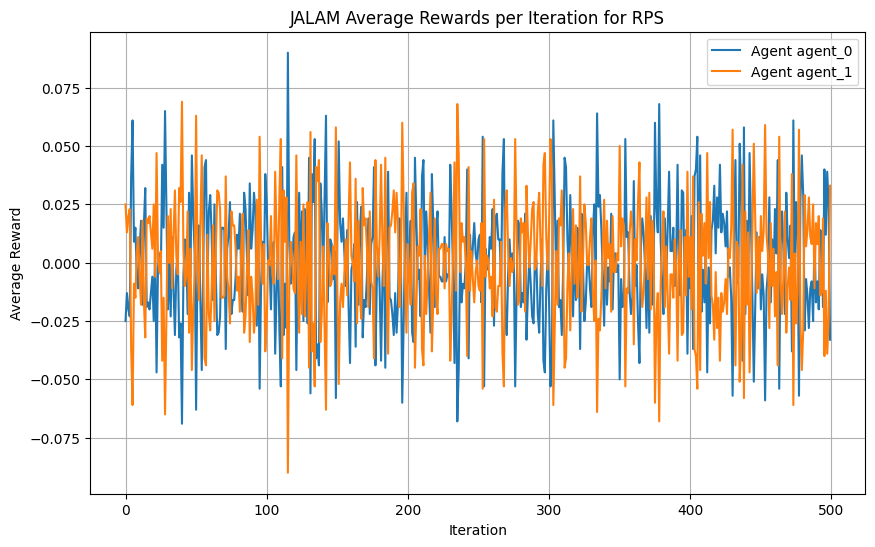

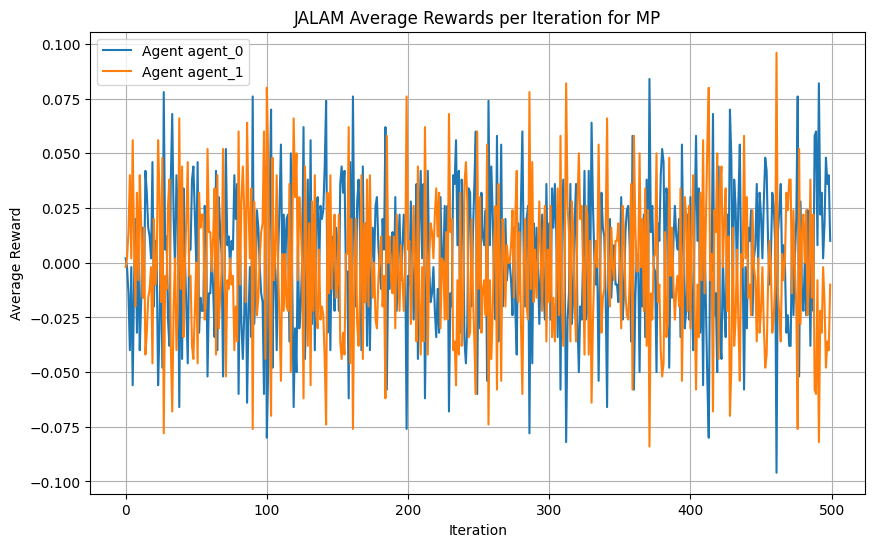

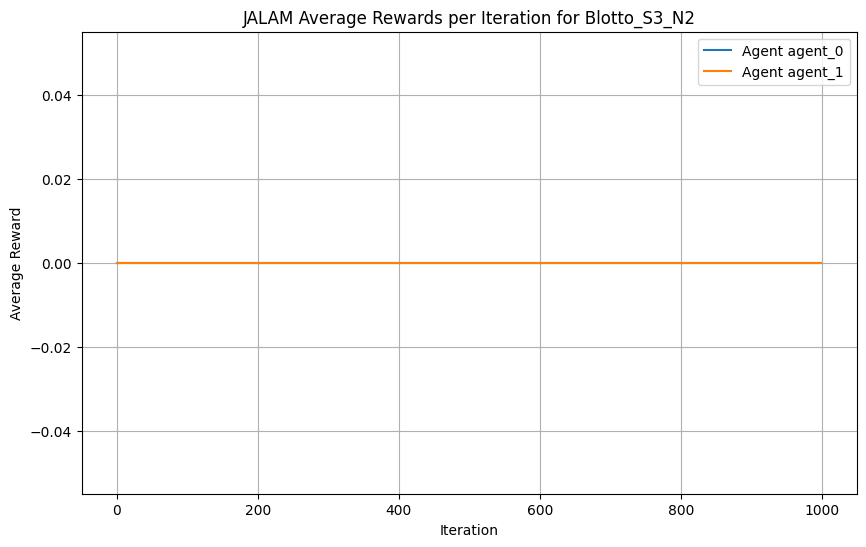

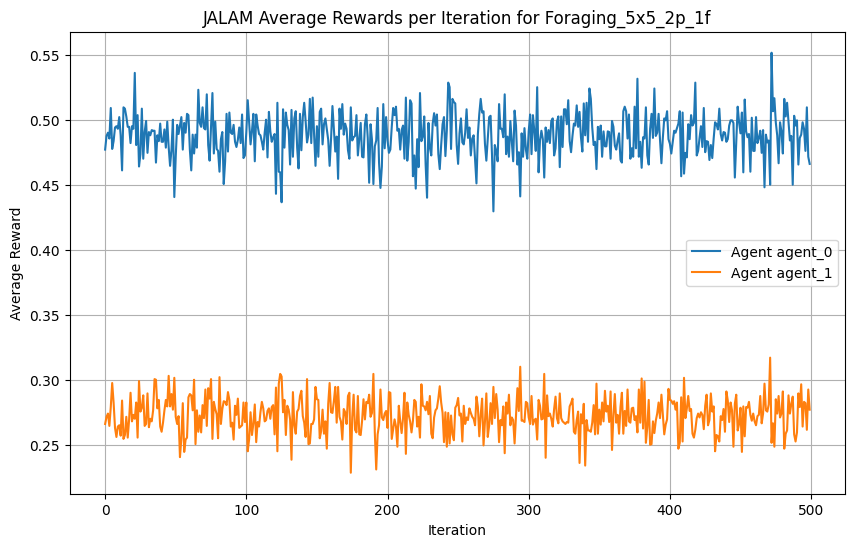

In [7]:
def plot_training_results(game_name, base_path):
    data_path = os.path.join(base_path, game_name, "training_rewards_jalam.pkl")
    if not os.path.exists(data_path):
        print(f"No training data found for {game_name} at {data_path}")
        return

    with open(data_path, 'rb') as f:
        training_rewards = pickle.load(f)

    plt.figure(figsize=(10, 6))
    for agent_id, rewards_list in training_rewards.items():
        plt.plot(rewards_list, label=f"Agent {agent_id}")
    
    plt.title(f"JALAM Average Rewards per Iteration for {game_name}")
    plt.xlabel("Iteration")
    plt.ylabel("Average Reward")
    plt.legend()
    plt.grid(True)
    plt.show()

if games_to_test:
    first_game_name = games_to_test[0]["name"]
    plot_training_results(first_game_name, TRAINING_DATA_DIR)
    
    second_game_name = games_to_test[1]["name"]
    plot_training_results(second_game_name, TRAINING_DATA_DIR)

    third_game_name = games_to_test[2]["name"]
    plot_training_results(third_game_name, TRAINING_DATA_DIR)

    fourth_game_name = games_to_test[3]["name"]
    plot_training_results(fourth_game_name, TRAINING_DATA_DIR)

## 5. Loading Trained JALAM Agents (Example for future use)

This section shows a conceptual way to load the saved models back into JALAM agents.

In [6]:
def load_agent_model(agent: JointActionLearningAgentModellingAgent, game_name: str, agent_id_str: str, base_path: str):
    """Loads a JALAM model into an agent from a file."""
    file_path = os.path.join(base_path, game_name, f"agent_{agent_id_str}_jalam_model.pkl")
    if not os.path.exists(file_path):
        print(f"  No JALAM model found for agent {agent_id_str} at {file_path}")
        return False
    
    try:
        with open(file_path, 'rb') as f:
            loaded_model = pickle.load(f)
        
        if 'Q_table' in loaded_model and hasattr(agent, 'Q_table'):
            agent.Q_table = loaded_model['Q_table']
        if 'model_counts' in loaded_model and hasattr(agent, 'model_counts'):
            agent.model_counts = loaded_model['model_counts']
        # if 'opponent_policy_models' in loaded_model and hasattr(agent, 'opponent_policy_models'):
        #    agent.opponent_policy_models = loaded_model['opponent_policy_models']
            
        agent.learn = False 
        if hasattr(agent, 'epsilon'):
            agent.epsilon = 0 # Act greedily for evaluation
        print(f"  Loaded JALAM model for agent {agent_id_str} from {file_path}")
        return True
    except Exception as e:
        print(f"  Error loading JALAM model for agent {agent_id_str}: {e}")
        return False

# Example of how you might load agents for a specific game:
# print("--- Example: Loading trained JALAM agents for RPS ---")
# rps_game_load_example = RPS() 
# # Agent config for loading (epsilon usually 0 for exploitation)
# jalam_load_config = {
#     "alpha": 0.1, "gamma": 0.99, "epsilon": 0.0, 
#     "min_epsilon": 0.0, "epsilon_decay": 0.0, "seed": None 
# }
# rps_agents_loaded = create_agents(rps_game_load_example, agent_config_params=jalam_load_config) 

# for agent_id_key, agent_obj_loaded in rps_agents_loaded.items():
#     agent_id_simple_load = str(rps_game_load_example.agent_name_mapping[agent_id_key])
#     load_agent_model(agent_obj_loaded, "RPS", agent_id_simple_load, TRAINING_DATA_DIR)

# Now rps_agents_loaded would contain agents with their models loaded.
# play_episode(rps_game_load_example, rps_agents_loaded, learn=False, render=True, verbose=True)